# Keyspace size
- We want this to match the read activity (9K ops/second)
- Will this be affected by # of WMs?
- How much of this can we cache?

In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
try: shutil.rmtree("tmp")
except: pass
os.mkdir("tmp")
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
 if (code_show){$('div.input').hide();}
 else {$('div.input').show();}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

In [97]:
def untar(fname):
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()

def parse_perfcounts(dfs, name, results):
    dirname = os.path.basename(results)
    if os.path.exists("tmp/perf-" + dirname):
        print "Found perfcounts; not untarring " + dirname,
    else:
        untar(results + "/out/perf.tar.gz")
        shutil.move("perf", "tmp/perf-" + dirname) 

    # get the min and max file names
    frange = []
    for f in glob.glob("tmp/perf-" + dirname + "/*"):
        fname = os.path.basename(f)
        ts = fname.split(".")[2]
        frange.append(int(ts))
        
    # get a large df
    list_ = []
    for ts in range(np.min(frange), np.max(frange)):
        file_ = "tmp/perf-" + dirname + "/perf.1."+str(ts)
        if not os.path.exists(file_):
            continue
        df = pd.read_csv(file_, names=['op', 'count', 'ts'])
        list_.append(df)
    dfs[(name, "1")] = pd.concat(list_)
    print "... DONE!",


In [3]:
dfs = {}
d = "../experiments/baseline-trinitite/"
parse_perfcounts(dfs, "4 Hour", d+"nano/parmsweep/scale-length-hr4-59971")
parse_perfcounts(dfs, "Delay 100K", d+"nano/scale-delay-100000-60684")
parse_perfcounts(dfs, "Delay 1M",   d+"nano/scale-delay-1000000-60685")
parse_perfcounts(dfs, "Delay 10M",  d+"nano/scale-delay-10000000-60686")

... DONE! ... DONE! ... DONE! ... DONE!


## 4 Hour Run, Delay 1M, 32 Cores

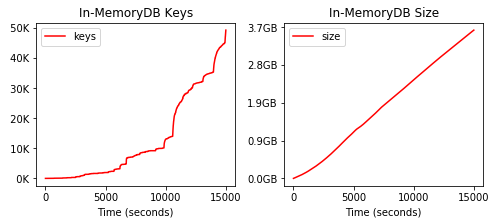

In [4]:
def plot_perfcounts(ax, dfs, name, op, label="", color='red'):
    df = dfs[(name, "1")]
    df = df[(df['op'] == op)]
    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    if label == "":
        ax.plot(df['ts'] - shift, df['count'], label=name, color=color)
    else:
        ax.plot(df['ts'] - shift, df['count'], label=label, color=color)
    ax.legend(loc='upper left')
    ax.set_xlabel("Time (seconds)")

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
fig.subplots_adjust(wspace=0.25)

ax[0].set_title("In-MemoryDB Keys")
plot_perfcounts(ax[0], dfs, "4 Hour", "DBMemory", label="keys", color='red')
ax[0].set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax[0].get_yticks()])

ax[1].set_title("In-MemoryDB Size")
plot_perfcounts(ax[1], dfs, "4 Hour", "DBMemorySize", label="size", color='red')
x = ax[1].set_yticklabels(['{:3.1f}GB'.format(yval/(1024*1024*1024)) for yval in ax[1].get_yticks()])

In [5]:
def print_stats(name):
    space = np.max(dfs[(name, "1")][dfs[(name, "1")]['op'] == "DBMemorySize"]['count'])
    nkeys = np.max(dfs[(name, "1")][dfs[(name, "1")]['op'] == "DBMemory"]['count'])
    print name + ":", str(nkeys), "keys,", str(space/(1024*1024)) + "MB, = " + str(space/(1024*nkeys)) + "KB/key" 

print_stats("4 Hour")
print_stats("Delay 10M")
print_stats("Delay 1M")
print_stats("Delay 100K")

4 Hour: 49249 keys, 3738MB, = 77KB/key
Delay 10M: 29 keys, 548MB, = 19380KB/key
Delay 1M: 1763 keys, 1019MB, = 592KB/key
Delay 100K: 107622 keys, 952MB, = 9KB/key


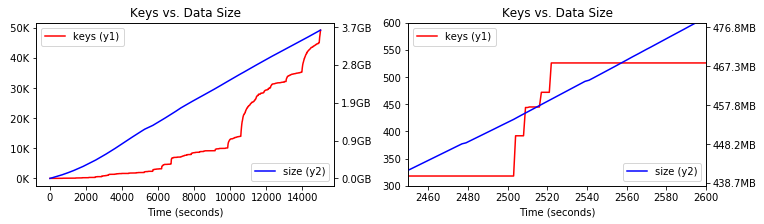

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)

ax[0].set_title("Keys vs. Data Size")
plot_perfcounts(ax[0], dfs, "4 Hour", "DBMemory", label="keys (y1)", color='red')
ax[0].set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax[0].get_yticks()])
ax2 = ax[0].twinx()
plot_perfcounts(ax2, dfs, "4 Hour", "DBMemorySize", label="size (y2)", color='blue')
ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1024*1024*1024)) for yval in ax2.get_yticks()])
ax2.legend(loc='lower right')

ax[1].set_title("Keys vs. Data Size")
plot_perfcounts(ax[1], dfs, "4 Hour", "DBMemory", label="keys (y1)", color='red')
ax2 = ax[1].twinx()
plot_perfcounts(ax2, dfs, "4 Hour", "DBMemorySize", label="size (y2)", color='blue')
ax2.legend(loc='lower right')
ax[1].set_ylim(300, 600)
ax[1].set_xlim(2450, 2600)
ax2.set_xlim(2450, 2600)
x = ax2.set_ylim(438*1024*1024, 478*1024*1024)
x = ax2.set_yticklabels(['{:3.1f}MB'.format(yval/(1024*1024)) for yval in ax2.get_yticks()])

In [7]:
dfs[("4 Hour", "1")][(dfs[("4 Hour", "1")]['op'] == "DBMemory") & (dfs[("4 Hour", "1")]['ts'] >= 1503107449)].head()

,op,count,ts
3,DBMemory,1,1503107449
3,DBMemory,1,1503107450
3,DBMemory,1,1503107451
3,DBMemory,29,1503107452
3,DBMemory,29,1503107453


In [8]:
dfs[("4 Hour", "1")][(dfs[("4 Hour", "1")]['op'] == "DBMemorySize") & (dfs[("4 Hour", "1")]['ts'] >= 1503107449)].head()

,op,count,ts
4,DBMemorySize,46099792,1503107449
4,DBMemorySize,46237600,1503107450
4,DBMemorySize,46375408,1503107451
4,DBMemorySize,46523624,1503107452
4,DBMemorySize,46675312,1503107453


```cpp
int STLLocalDataStore::put(unsigned int dbKey, uint64_t &key, Rd &data){
        INC(DBMemoryPut);
        debug_perf("DBMemoryPut," << dbKey << "," << key);

        if( dbm.count(dbKey)==0 ) {
                return DBKEY_NOTFOUND;
        }
        bool allowDuplicates=dbAttributes[dbKey].first;

        if(allowDuplicates or count(dbKey, key)==0) {
                dbm[dbKey].insert(std::make_pair(key,data));
                storedKeys[dbKey].insert(key);
                size_t s = data.size();
                INC(DBMemory);
                ADD(DBMemorySize, s);
                currentSize+=s;
        }

        INC(DBMemoryMRU);
        debug_perf("DBMemoryMRUPut," << dbKey << "," << key);
        mru.touch(std::make_pair(dbKey,key));

        return 0;

};
```


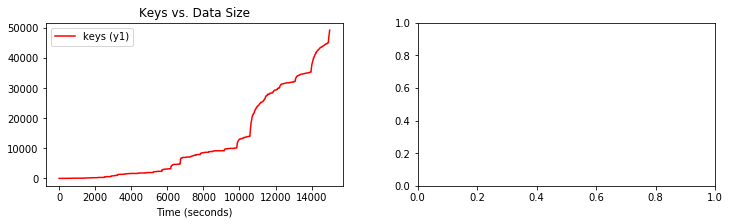

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)

ax[0].set_title("Keys vs. Data Size")
plot_perfcounts(ax[0], dfs, "4 Hour", "DBMemory", label="keys (y1)", color='red')


In [77]:
df = pd.read_csv("../experiments/baseline-trinitite/nano/scale-delay-1000000-61843/out/perf.1", names=['ts', 'op', 'count'])
df.head(25)

,ts,op,count
0,1503608671,DBMemoryPut,1000
1,1503608671,DBMemoryGet,2025
2,1503608671,DBMemorySync,0
3,1503608671,DBMemory,1
4,1503608671,DBMemorySize,464000
5,1503608671,DBMemoryMRU,2951
6,1503608671,DriverPull,0
7,1503608671,DriverProc,0
8,1503608671,DriverPush,0
9,1503608671,ManagerSend,86904


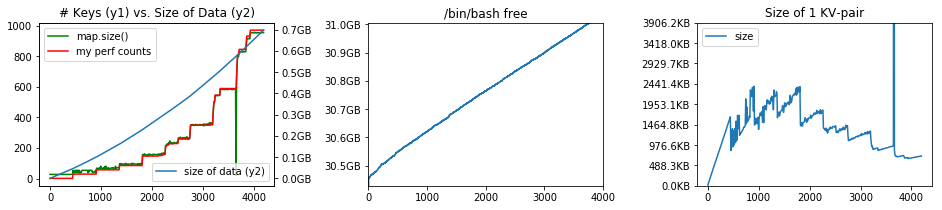

In [95]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))
fig.subplots_adjust(wspace=0.4)

ax[0].set_title("# Keys (y1) vs. Size of Data (y2)")
df_op = df[df['op'] == 'DBMemoryMapSize']
shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
ax[0].plot(df_op['ts'] - shift, df_op['count'], label="map.size()", color='green')
df_op = df[df['op'] == 'DBMemory']
ax[0].plot(df_op['ts'] - shift, df_op['count'], label="my perf counts", color='red')
ax2 = ax[0].twinx()
df_op = df[df['op'] == 'DBMemorySize']
ax2.plot(df_op['ts'] - shift, df_op['count'], label="size of data (y2)")
ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1024*1024*1024)) for yval in ax2.get_yticks()])
ax2.legend(loc='lower right')

ax[1].set_title("/bin/bash free")
x = []; y = []; first = -1
with open("../experiments/baseline-trinitite/nano/scale-delay-1000000-61843/out/mem.out") as f:
    for line in f:
        words = line.split(',')
        x.append(int(words[0]))
        y.append(int(' '.join(words[1].split()).split(' ')[2]))
shift = x[0]*np.ones(len(x))
ax[1].plot(x - shift, y)
ax[1].set_xlim(0, 4000)
ax[1].set_ylim(30.45*1024*1024, 31*1024*1024)
ax[1].set_yticklabels(['{:3.1f}GB'.format(yval/(1024*1024)) for yval in ax[1].get_yticks()])

ax[2].set_title("Size of 1 KV-pair")
df_data = df[df['op'] == 'DBMemorySize']
df_keys = df[df['op'] == 'DBMemoryMapSize']
joined = pd.merge(df_data, df_keys, on='ts')
joined['size'] = joined['count_x']/joined['count_y']
shift = np.min(joined['ts']) * np.ones(len(joined['ts']))
ax[2].plot(joined['ts'] - shift, joined['size'])
ax[2].set_ylim(0, 4000000)
ax[2].set_yticklabels(['{:3.1f}KB'.format(yval/(1024)) for yval in ax[2].get_yticks()])

for a in range(0, len(ax)):
    ax[a].legend()
    #ax[a].set_xticklabels([])

## The problem is duplicate puts are occuring...
... even though `count(dbKey, key)==0)` should disallow this

In [13]:
names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        for op in ["DBMemoryPut", "DBMemoryGet", "DBMemoryPutUnique", "DBMemoryGetDel"]:
            os.system("cat " + results + "/out/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
            print "...", op, 
    return stats

parse(dfs, "Delay 1M", "../experiments/baseline-trinitite/nano/scale-delay-1000000-61843")


... DBMemoryPut ... DBMemoryGet ... DBMemoryPutUnique ... DBMemoryPut ... DBMemoryGet ... DBMemoryPutUnique ... DBMemoryPut ... DBMemoryGet ... DBMemoryPutUnique ... DBMemoryGetDel

['Delay 1M DBMemoryPut Splicer: nkeys=13, hottest key=11669211761296708093 (count=2)',
 'Delay 1M DBMemoryGet Splicer: nkeys=13, hottest key=13397889897772269455 (count=2)',
 'Delay 1M DBMemoryPutUnique Splicer: nkeys=13, hottest key=11669211761296708093 (count=1)',
 'Delay 1M DBMemoryPut InMemoryDB: nkeys=29, hottest key=11669211761296708093 (count=2)',
 'Delay 1M DBMemoryGet InMemoryDB: nkeys=29, hottest key=11669211761296708093 (count=2)',
 'Delay 1M DBMemoryPutUnique InMemoryDB: nkeys=29, hottest key=11669211761296708093 (count=1)',
 'Delay 1M DBMemoryPut WorkManager: nkeys=36, hottest key=5759579832777875882 (count=240126)',
 'Delay 1M DBMemoryGet WorkManager: nkeys=36, hottest key=5759579832777875882 (count=348170)',
 'Delay 1M DBMemoryPutUnique WorkManager: nkeys=32, hottest key=5759579832777875882 (count=120063)',
 'Delay 1M DBMemoryGetDel WorkManager: nkeys=30, hottest key=5759579832777875882 (count=116386)']

In [14]:
def plot_keytimes(ax, dfs, key_tuple, shift=0, nkeys=50):
    color = plt.cm.jet(np.linspace(0, 1, nkeys)) # get more colors (equal to number of keys)
    c_idx = np.arange(0, nkeys)                  # create an array of indices
    np.random.shuffle(c_idx)                     # randomly assign colors
    
    # get top n keys
    df = dfs[key_tuple]['DF_KEY_COUNT']          # get the count df for this run
    df = df.nlargest(nkeys, 'count')             # get the keys that show up the most
    df = df.head(nkeys)                          # not sure why we need to do head here

    i = 0
    print key_tuple[0] + " UNIQUE KEYS=" + str(len(df['key'])) + " pulling from " + str(len(dfs[key_tuple]['DF_KEY_COUNT']))
    for key in df['key']:
        
        # group this key's timestamps for this op
        d = dfs[key_tuple]['DF_KEY_TIMES']       # now we need the raw df for this run
        d = d[(d['key'] == key)]                 # focus only on this key
        n = str(len(d))                          # save off the total number of ops
        d = d.groupby('ts').size()             # count the number of ops at each timestamp
        d = d.reset_index()                      # flip the axes
        d.columns = ['ts', 'count']            # label the axes

        # plot df if it's not empty
        if len(d) == 0: continue
        first   = np.min(d['ts'])              # we need to do some timestamp finnagling
        last    = np.max(d['ts'])
        tsrange = last - first + 1
        x = np.arange(tsrange + 2) + first       # x axis is shifted by real time (+2 so NULL plot to 0)
        y = np.zeros(tsrange + 2)                # y axis starts as array of zeros...
        for k, v in d.iterrows():                # ... but is filled in w/ counts for that ts
            idx    = v['ts'] - first + 1       # overwrite value (shifted to account for ts and initial 0)
            y[idx] = v['count']
        ax.plot(x, y, color=color[c_idx[0]], label=n)
        c_idx = np.delete(c_idx, 0)              # get a unique color but don't use it again


Delay 1M UNIQUE KEYS=34 pulling from 32
Delay 1M UNIQUE KEYS=38 pulling from 36


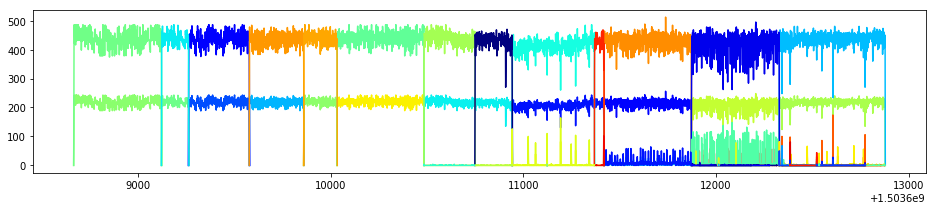

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
plot_keytimes(ax, dfs, ("Delay 1M",   "DBMemoryPutUnique", "4"), nkeys=200)
plot_keytimes(ax, dfs, ("Delay 1M",   "DBMemoryPut", "4"), nkeys=200)


Delay 1M UNIQUE KEYS=34 pulling from 30


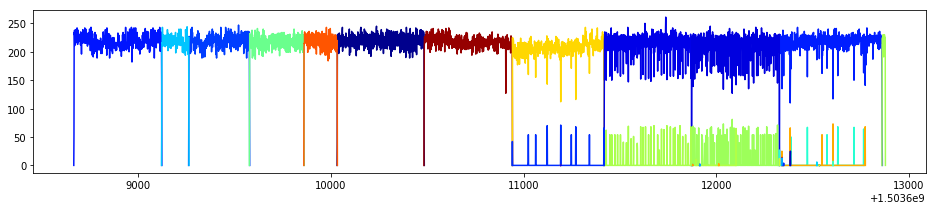

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
plot_keytimes(ax, dfs, ("Delay 1M",   "DBMemoryGetDel", "4"), nkeys=200)
#plot_keytimes(ax, dfs, ("Delay 1M",   "DBMemoryPut", "4"), nkeys=200)


# Check the memory usage for 4 horus

In [137]:
shutil.rmtree("tmp")
os.mkdir("tmp")
untar("../experiments/baseline-trinitite/nano/scale-delay-4hr-100000-61892/out/perf.tar.gz")
untar("../experiments/baseline-trinitite/nano/scale-delay-4hr-100000-61892/out/mem.out.tar.gz")
shutil.move("perf", "tmp/perf-100K")
shutil.move("mem.out", "tmp/perf-100K/mem.out")
df = pd.read_csv("tmp/perf-100K/perf.1", names=['ts', 'op', 'count'])
df.head()

,ts,op,count
0,1503673161,DBMemoryPut,1079
1,1503673161,DBMemoryGet,2183
2,1503673161,DBMemorySync,0
3,1503673161,DBMemory,1
4,1503673161,DBMemorySize,500656


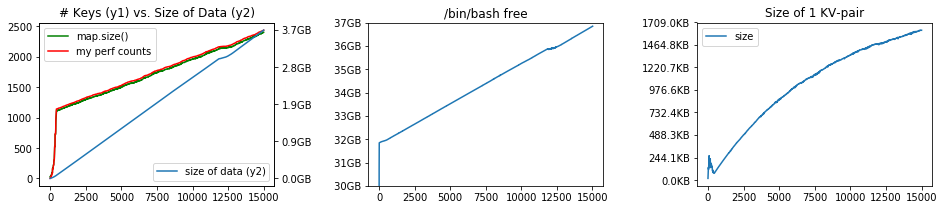

In [138]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))
fig.subplots_adjust(wspace=0.4)

ax[0].set_title("# Keys (y1) vs. Size of Data (y2)")
df_op = df[df['op'] == 'DBMemoryMapSize']
shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
ax[0].plot(df_op['ts'] - shift, df_op['count'], label="map.size()", color='green')
df_op = df[df['op'] == 'DBMemory']
ax[0].plot(df_op['ts'] - shift, df_op['count'], label="my perf counts", color='red')
ax2 = ax[0].twinx()
df_op = df[df['op'] == 'DBMemorySize']
ax2.plot(df_op['ts'] - shift, df_op['count'], label="size of data (y2)")
ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1024*1024*1024)) for yval in ax2.get_yticks()])
ax2.legend(loc='lower right')

ax[1].set_title("/bin/bash free")
x = []; y = []; first = -1
with open("tmp/perf-100K/mem.out") as f:
    for line in f:
        words = line.split(',')
        x.append(int(words[0]))
        y.append(int(' '.join(words[1].split()).split(' ')[2]))
shift = x[0]*np.ones(len(x))
ax[1].plot(x - shift, y)
ax[1].set_ylim(30*1000*1000, 37*1000*1000)
ax[1].set_yticklabels(['{:3.0f}GB'.format(yval/(1000*1000)) for yval in ax[1].get_yticks()])

ax[2].set_title("Size of 1 KV-pair")
df_data = df[df['op'] == 'DBMemorySize']
df_keys = df[df['op'] == 'DBMemoryMapSize']
joined = pd.merge(df_data, df_keys, on='ts')
joined['size'] = joined['count_x']/joined['count_y']
shift = np.min(joined['ts']) * np.ones(len(joined['ts']))
ax[2].plot(joined['ts'] - shift, joined['size'])
ax[2].set_yticklabels(['{:3.1f}KB'.format(yval/(1024)) for yval in ax[2].get_yticks()])

for a in range(0, len(ax)):
    ax[a].legend()
    #ax[a].set_xticklabels([])

In [139]:
untar("../experiments/baseline-trinitite/nano/scale-delay-4hr-1000000-61891/out/perf.tar.gz")
untar("../experiments/baseline-trinitite/nano/scale-delay-4hr-1000000-61891/out/mem.out.tar.gz")
shutil.move("perf", "tmp/perf-1M")
shutil.move("mem.out", "tmp/perf-1M/mem.out")
df = pd.read_csv("tmp/perf-1M/perf.1", names=['ts', 'op', 'count'])
df.head()

,ts,op,count
0,1503673161,DBMemoryPut,970
1,1503673161,DBMemoryGet,1965
2,1503673161,DBMemorySync,0
3,1503673161,DBMemory,1
4,1503673161,DBMemorySize,450080


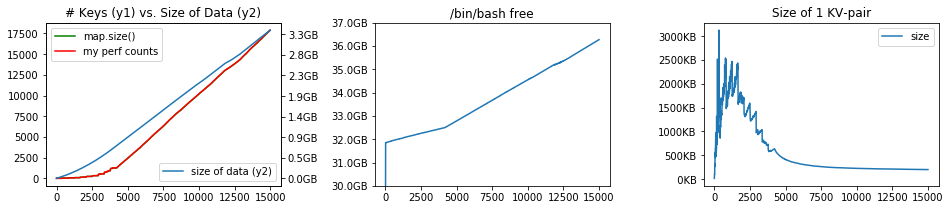

In [145]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))
fig.subplots_adjust(wspace=0.4)

ax[0].set_title("# Keys (y1) vs. Size of Data (y2)")
df_op = df[df['op'] == 'DBMemoryMapSize']
shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
ax[0].plot(df_op['ts'] - shift, df_op['count'], label="map.size()", color='green')
df_op = df[df['op'] == 'DBMemory']
ax[0].plot(df_op['ts'] - shift, df_op['count'], label="my perf counts", color='red')
ax2 = ax[0].twinx()
df_op = df[df['op'] == 'DBMemorySize']
ax2.plot(df_op['ts'] - shift, df_op['count'], label="size of data (y2)")
ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1024*1024*1024)) for yval in ax2.get_yticks()])
ax2.legend(loc='lower right')

ax[1].set_title("/bin/bash free")
x = []; y = []; first = -1
with open("tmp/perf-1M/mem.out") as f:
    for line in f:
        words = line.split(',')
        x.append(int(words[0]))
        y.append(int(' '.join(words[1].split()).split(' ')[2]))
shift = x[0]*np.ones(len(x))
ax[1].plot(x - shift, y)
ax[1].set_ylim(30*1000*1000, 37*1000*1000)
ax[1].set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000)) for yval in ax[1].get_yticks()])

ax[2].set_title("Size of 1 KV-pair")
df_data = df[df['op'] == 'DBMemorySize']
df_keys = df[df['op'] == 'DBMemoryMapSize']
joined = pd.merge(df_data, df_keys, on='ts')
joined['size'] = joined['count_x']/joined['count_y']
shift = np.min(joined['ts']) * np.ones(len(joined['ts']))
ax[2].plot(joined['ts'] - shift, joined['size'])
ax[2].set_yticklabels(['{:3.0f}KB'.format(yval/(1000)) for yval in ax[2].get_yticks()])

for a in range(0, len(ax)):
    ax[a].legend()
    #ax[a].set_xticklabels([])